In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm
import seaborn as sns


Text(0.5, 0, '$y$')

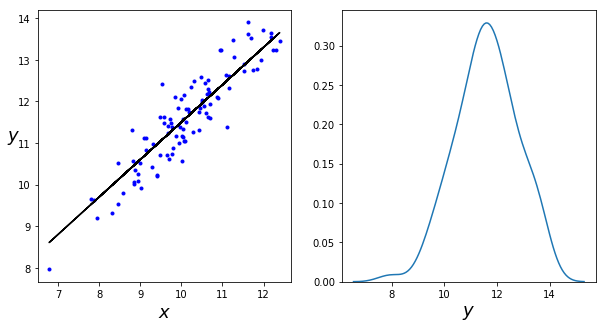

In [26]:
'''参数真实值'''
np.random.seed(314)
n = 100#样本数
alfa_real = 2.5
beta_real = 0.9
eps_real = np.random.normal(0, 0.5, size=n)

'''构造数据集'''
x = np.random.normal(10, 1, n)
y_real = alfa_real + beta_real * x
y = y_real +eps_real

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
#绘制散点
plt.plot(x, y, 'b.')
plt.xlabel('$x$', fontsize=18)
plt.ylabel('$y$', fontsize=18, rotation=0)
#绘制回归线
plt.plot(x, y_real, 'k')

plt.subplot(1,2,2)
sns.kdeplot(y)
plt.xlabel('$y$', fontsize=18)


In [27]:
'''模型构建'''
with pm.Model() as model_a:
    #先验设置
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta = pm.Normal('beta', mu=0, sd=1)
    epsilon = pm.HalfCauchy('epsilon', 5)
    
    mu = pm.Deterministic('mu', alpha + beta * x)
    y_pred= pm.Normal('y_pred', mu=mu, sd=epsilon, observed=y )
    
    start = pm.find_MAP()
    step = pm.Metropolis()
    trace = pm.sample(10000, step, start)
    

C:\Users\Forry\Anaconda3\lib\site-packages\pymc3\tuning\starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = -71.578, ||grad|| = 0.14936: 100%|█████████████████████████████████████████████| 36/36 [00:00<00:00, 880.40it/s]
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [epsilon]
>Metropolis: [beta]
>Metropolis: [alpha]
Sampling 2 chains: 100%|█████████████████████████████████████████████████████| 21000/21000 [00:24<00:00, 854.64draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000021C1FD30400>,
      dtype=object)

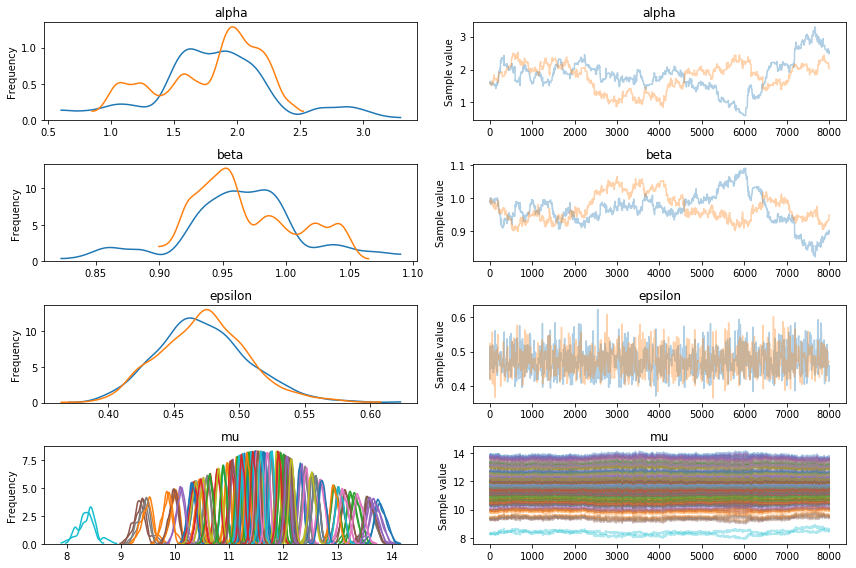

In [28]:
chain = trace[2000:]
pm.traceplot(chain)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000022C39B750F0>,
      dtype=object)

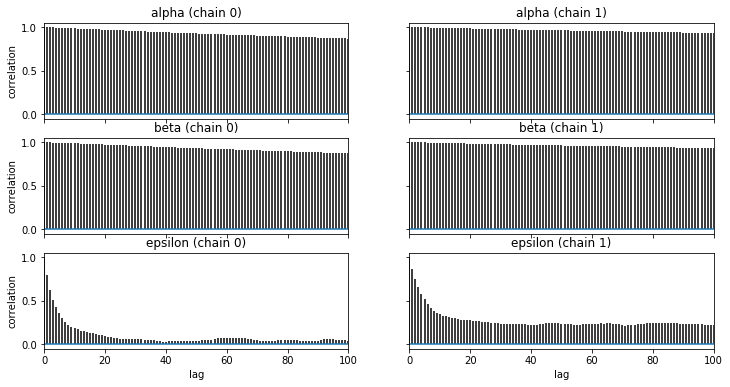

In [12]:
varnames = ['alpha', 'beta', 'epsilon']
pm.autocorrplot(trace, varnames)

Text(0, 0.5, '$\\beta$')

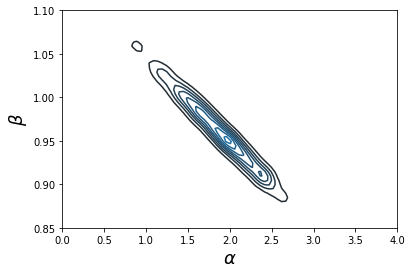

In [19]:
sns.kdeplot(trace['alpha'], trace['beta'])
plt.ylim(0.85, 1.1)
plt.xlim([0, 4])
plt.xlabel(r'$\alpha$', fontsize=18)
plt.ylabel(r'$\beta$', fontsize=18)

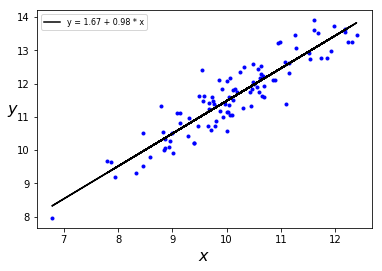

In [5]:
'''NUTS采样方法'''

#后验初步可视化
plt.plot(x, y, 'b.')
alpha_m = trace['alpha'].mean()
beta_m = trace['beta'].mean()
plt.plot(x, alpha_m + beta_m * x, c='k', 
        label = 'y = {:.2f} + {:.2f} * x'.format(alpha_m, beta_m))
plt.xlabel('$x$', fontsize=16)
plt.ylabel('$y$', fontsize=16, rotation=0)
plt.legend(loc=2, fontsize=8)

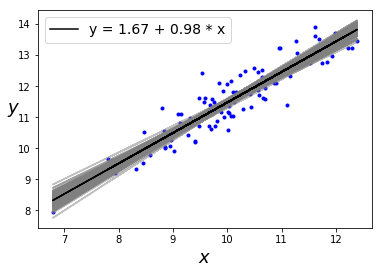

In [29]:
#从后验采样中画出半透明直线表示后验不确定性
plt.plot(x, y, 'b.')#绘制散点

idx = range(0, len(trace['alpha']), 100)
plt.plot(x, trace['alpha'][idx] + trace['beta'][idx] * x[:,np.newaxis],
        c='gray', alpha=0.5)
plt.plot(x, alpha_m + beta_m * x, c='k', label='y = {:.2f} + {:.2f} * x'.format(alpha_m, beta_m) )

plt.xlabel('$x$', fontsize=18)
plt.ylabel('$y$', fontsize=18, rotation=0)
plt.legend(loc=2, fontsize=14)

Text(0, 0.5, '$y$')

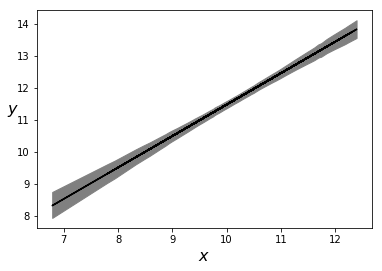

In [32]:
#用半透明区间描述mu的最大后验密度（HPD）区间
plt.plot(x, alpha_m + beta_m * x, c='k', 
        label='y = {:.2f} + {:.2f} * x'.format(alpha_m, beta_m))
idx = np.argsort(x)
x_ord = x[idx]
sig = pm.hpd(trace['mu'], alpha=.02)[idx]
plt.fill_between(x_ord, sig[:,0], sig[:,1], color='gray')

plt.xlabel('$x$', fontsize=16)
plt.ylabel('$y$', fontsize=16, rotation=0)


C:\Users\Forry\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: sample_ppc() is deprecated.  Please use sample_posterior_predictive()
  This is separate from the ipykernel package so we can avoid doing imports until
100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1524.81it/s]


Text(0, 0.5, '$y$')

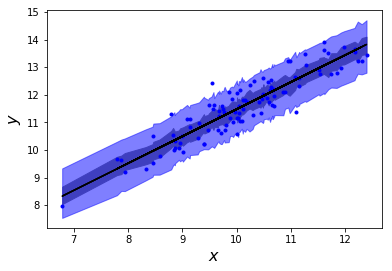

In [33]:
#画预测值y帽的HPD区间（95%和50%）

ppc = pm.sample_ppc(chain, samples=1000, model=model_a)#获得预测值的采样值

plt.plot(x, y, 'b.')
plt.plot(x, alpha_m + beta_m * x, c='k', 
        label = 'y = {:.2f} + {:.2f} * x'.format(alpha_m, beta_m))

#idx = range(0,100)
sig0 = pm.hpd(ppc['y_pred'], alpha=0.5)[idx]
sig1 = pm.hpd(ppc['y_pred'], alpha=0.05)[idx]
plt.fill_between(x_ord, sig0[:,0], sig0[:,1], color='gray', alpha=1)#灰色表示50%HPD区间
plt.fill_between(x_ord, sig1[:,0], sig1[:,1], color='blue', alpha=0.5)#蓝色表示95%HPD区间

plt.xlabel('$x$', fontsize=16)
plt.ylabel('$y$', fontsize=16)

